In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
import tensorflow as tf
import time

from datasets import dataset_utils

# Main slim library
from tensorflow.contrib import slim

In [2]:
import tensorflow as tf
from datasets import dataset_utils

url = "http://download.tensorflow.org/data/flowers.tar.gz"
flowers_data_dir = '/tmp/flowers'

if not tf.gfile.Exists(flowers_data_dir):
    tf.gfile.MakeDirs(flowers_data_dir)

dataset_utils.download_and_uncompress_tarball(url, flowers_data_dir) 

>> Downloading flowers.tar.gz 100.0%
Successfully downloaded flowers.tar.gz 228649660 bytes.


### Display some of the data.

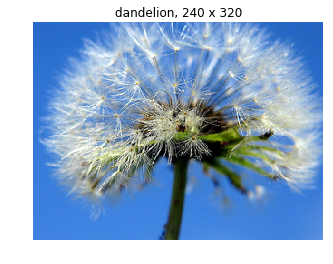

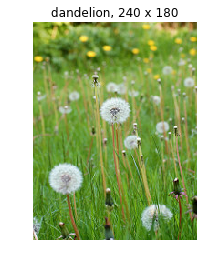

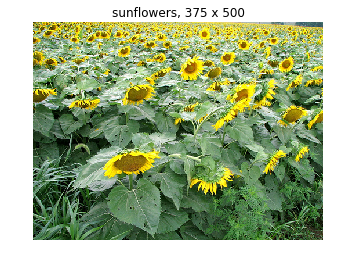

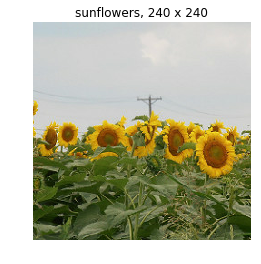

In [3]:
from datasets import flowers
import tensorflow as tf

from tensorflow.contrib import slim

with tf.Graph().as_default(): 
    dataset = flowers.get_split('train', flowers_data_dir)
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32, common_queue_min=1)
    image, label = data_provider.get(['image', 'label'])
    
    with tf.Session() as sess:    
        with slim.queues.QueueRunners(sess):
            for i in range(4):
                np_image, np_label = sess.run([image, label])
                height, width, _ = np_image.shape
                class_name = name = dataset.labels_to_names[np_label]
                
                plt.figure()
                plt.imshow(np_image)
                plt.title('%s, %d x %d' % (name, height, width))
                plt.axis('off')
                plt.show()

# Convolutional neural nets (CNNs).
<a id='CNN'></a>

In this section, we show how to train an image classifier using a simple CNN.


### Define the model.

Below we define a simple CNN. Note that the output layer is linear function - we will apply softmax transformation externally to the model, either in the loss function (for training), or in the prediction function (during testing).

In [4]:
from preprocessing import inception_preprocessing
import tensorflow as tf

from tensorflow.contrib import slim


def load_batch(dataset, batch_size=32, height=299, width=299, is_training=False):
    """Loads a single batch of data.
    
    Args:
      dataset: The dataset to load.
      batch_size: The number of images in the batch.
      height: The size of each image after preprocessing.
      width: The size of each image after preprocessing.
      is_training: Whether or not we're currently training or evaluating.
    
    Returns:
      images: A Tensor of size [batch_size, height, width, 3], image samples that have been preprocessed.
      images_raw: A Tensor of size [batch_size, height, width, 3], image samples that can be used for visualization.
      labels: A Tensor of size [batch_size], whose values range between 0 and dataset.num_classes.
    """
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32,
        common_queue_min=8)
    image_raw, label = data_provider.get(['image', 'label'])
    
    # Preprocess image for usage by Inception.
    image = inception_preprocessing.preprocess_image(image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, labels = tf.train.batch(
          [image, image_raw, label],
          batch_size=batch_size,
          num_threads=1,
          capacity=2 * batch_size)
    
    return images, images_raw, labels

# Using pre-trained models
<a id='Pretrained'></a>

Neural nets work best when they have many parameters, making them very flexible function approximators.
However, this  means they must be trained on big datasets. Since this process is slow, we provide various pre-trained models - see the list [here](https://github.com/tensorflow/models/tree/master/slim#pre-trained-models).


You can either use these models as-is, or you can perform "surgery" on them, to modify them for some other task. For example, it is common to "chop off" the final pre-softmax layer, and replace it with a new set of weights corresponding to some new set of labels. You can then quickly fine tune the new model on a small new dataset. We illustrate this below, using inception-v1 as the base model. While models like Inception V3 are more powerful, Inception V1 is used for speed purposes.

Take into account that VGG and ResNet final layers have only 1000 outputs rather than 1001. The ImageNet dataset provied has an empty background class which can be used to fine-tune the model to other tasks. VGG and ResNet models provided here don't use that class. We provide two examples of using pretrained models: Inception V1 and VGG-19 models to highlight this difference.


### Download the Inception V1 checkpoint




In [5]:
from datasets import dataset_utils

url = "http://download.tensorflow.org/models/inception_v1_2016_08_28.tar.gz"
checkpoints_dir = '/tmp/checkpoints'

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)

dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)

>> Downloading inception_v1_2016_08_28.tar.gz 100.0%
Successfully downloaded inception_v1_2016_08_28.tar.gz 24642554 bytes.


### Fine-tune the model on a different set of labels.

We will fine tune the inception model on the Flowers dataset.

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from os import listdir, path, makedirs
from os.path import isfile, isdir, join, basename

# base_path = '/Users/ali.jeon/gitlab/ocr/preprocessing/phd08_output'
base_path = 'phd08_output_all'

def read_charlist(base_path):
    data_filenames = [path.splitext(f)[0] for f in listdir(base_path) if isfile(join(base_path, f)) and f.lower().endswith('.csv.100')]        
    
    return data_filenames
        
data_filenames = read_charlist(base_path)
data_filenames = data_filenames[:20]

label_idx = {x:idx for idx, x in enumerate(sorted(data_filenames))}
label_name = {idx:x for idx, x in enumerate(sorted(data_filenames))}

def get_inputs(batch_size=256, height=56, width=56, is_training=False):
    # Create a queue that produces the filenames to read.
    filenames = [join(base_path, '.'.join([char, '100'])) for char in data_filenames]
    filename_queue = tf.train.string_input_producer(filenames)
    line_reader = tf.TextLineReader()
    # Read a whole file from the queue, the first returned value in the tuple is the
    # filename which we are ignoring.
    _, csv_row = line_reader.read(filename_queue)
    
    '''
        Columns:
        FO(1): Font type (B:바다, D:돋움, G:고딕, H1:한양해서, H2:헤드라인, M:명조, N:나무, S:샘물, Y:엽서)
        FS(1): Font size (0:12, 1:13: 2:14)
        CP(1): The number of copies (0:0, 1:1, 2:2)
        RE(1): Resolution (0:200, 1:240, 2:280)
        TH(1): Threshold (0:140, 1:180, 2:220)
        SL(1): Slope(Rotate) (0:-3deg, 1:0deg, 2:3deg)
        HE(1): Height(pixels)
        WD(1): Width(pixels)
        Korean Character(1) (가, 각, 간, ...)
        Image data(The number of columns = Rows X Cols)
        Label(1): (0:가, 1:각, 2:간 ...)

    '''
    record_defaults = [
        [''], # FO
        [''], # FS
        [0],  # CP
        [0],  # RE
        [0],  # TH
        [0],  # SL
        [0],  # HE
        [0],  # WD
        [''],  # Kor char.
    ] + [[0]] * (56*56) + [[0]]

    columns = tf.decode_csv(csv_row, record_defaults=record_defaults)
    character = columns[8]
    image_raw = tf.reshape(tf.stack(columns[9:-1]), [56, 56, 1])
    image_raw = tf.cast(image_raw, tf.float32)
    image_raw = tf.image.grayscale_to_rgb(image_raw)
    
    # Preprocess image for usage by Inception.
    image = inception_preprocessing.preprocess_image(image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)
    
    label = columns[-1]
    
    '''
    To check valid input
    '''
    num_preprocess_threads = 1
    min_queue_examples = 256
    
    # Batch it up.
    images, images_raw, labels = tf.train.shuffle_batch(
          [image, image_raw, label],
          batch_size=batch_size,
          num_threads=1,
          capacity=4 * batch_size,
        min_after_dequeue=batch_size * 2,
    )
    
    return images, images_raw, labels

get_inputs()

(<tf.Tensor 'shuffle_batch_1:0' shape=(256, 56, 56, 3) dtype=float32>,
 <tf.Tensor 'shuffle_batch_1:1' shape=(256, 56, 56, 3) dtype=float32>,
 <tf.Tensor 'shuffle_batch_1:2' shape=(256,) dtype=int32>)

In [12]:
NUM_CLASSES = len(label_idx)
NUM_CLASSES

14

In [13]:
label_name = {idx:x for idx, x in enumerate(sorted(data_filenames))}

In [17]:
# Note that this may take several minutes.

import os

import tensorflow as tf

from datasets import flowers
from nets import inception
from preprocessing import inception_preprocessing

from tensorflow.contrib import slim
image_size = inception.inception_v1.default_image_size


def get_init_fn():
    """Returns a function run by the chief worker to warm-start the training."""
    checkpoint_exclude_scopes=["InceptionV1/Logits", "InceptionV1/AuxLogits"]
    
    exclusions = [scope.strip() for scope in checkpoint_exclude_scopes]

    variables_to_restore = []
    for var in slim.get_model_variables():
        excluded = False
        for exclusion in exclusions:
            if var.op.name.startswith(exclusion):
                excluded = True
                break
        if not excluded:
            variables_to_restore.append(var)

    return slim.assign_from_checkpoint_fn(
      os.path.join(checkpoints_dir, 'inception_v1.ckpt'),
      variables_to_restore)

train_dir = '/tmp/inception_finetuned/'

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    images, _, labels = get_inputs(height=image_size, width=image_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(images, num_classes=NUM_CLASSES, is_training=True)
        
    # Specify the loss function:
    one_hot_labels = slim.one_hot_encoding(labels, NUM_CLASSES)
    slim.losses.softmax_cross_entropy(logits, one_hot_labels)
    total_loss = slim.losses.get_total_loss()

    # Create some summaries to visualize the training process:
    tf.summary.scalar('losses/Total Loss', total_loss)
    
    tf.summary.histogram('labels', labels)
  
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)w
    train_op = slim.learning.create_train_op(total_loss, optimizer)
    
    # Run the training:
    final_loss = slim.learning.train(
        train_op,
        logdir=train_dir,
        init_fn=get_init_fn(),
        number_of_steps=1000)
        
print('Finished training. Last batch loss %f' % final_loss)

INFO:tensorflow:Summary name losses/Total Loss is illegal; using losses/Total_Loss instead.
INFO:tensorflow:Restoring parameters from /tmp/inception_finetuned/model.ckpt-159
INFO:tensorflow:Starting Session.
INFO:tensorflow:Saving checkpoint to path /tmp/inception_finetuned/model.ckpt
INFO:tensorflow:Starting Queues.
INFO:tensorflow:Recording summary at step 159.
INFO:tensorflow:global step 160: loss = 0.4047 (71.663 sec/step)
INFO:tensorflow:global step 161: loss = 0.4022 (46.927 sec/step)
INFO:tensorflow:global step 162: loss = 0.4017 (43.418 sec/step)
INFO:tensorflow:global step 163: loss = 0.3993 (45.339 sec/step)
INFO:tensorflow:global step 164: loss = 0.3980 (48.227 sec/step)
INFO:tensorflow:global step 165: loss = 0.3962 (119.284 sec/step)
INFO:tensorflow:global step 166: loss = 0.3949 (82.893 sec/step)
INFO:tensorflow:global step 167: loss = 0.3938 (39.305 sec/step)
INFO:tensorflow:global step 168: loss = 0.3922 (38.749 sec/step)
INFO:tensorflow:global step 169: loss = 0.3908 (

INFO:tensorflow:global step 267: loss = 0.2718 (53.692 sec/step)
INFO:tensorflow:Saving checkpoint to path /tmp/inception_finetuned/model.ckpt
INFO:tensorflow:Recording summary at step 267.
INFO:tensorflow:global step 268: loss = 0.2709 (70.089 sec/step)
INFO:tensorflow:global step 269: loss = 0.2701 (56.866 sec/step)
INFO:tensorflow:global step 270: loss = 0.2689 (59.210 sec/step)
INFO:tensorflow:global step 271: loss = 0.2678 (57.472 sec/step)
INFO:tensorflow:global step 272: loss = 0.2668 (66.552 sec/step)
INFO:tensorflow:global step 273: loss = 0.2658 (55.666 sec/step)
INFO:tensorflow:global step 274: loss = 0.2650 (58.961 sec/step)
INFO:tensorflow:global step 275: loss = 0.2641 (49.774 sec/step)
INFO:tensorflow:global step 276: loss = 0.2629 (45.438 sec/step)
INFO:tensorflow:global step 277: loss = 0.2620 (44.633 sec/step)
INFO:tensorflow:global step 278: loss = 0.2614 (50.544 sec/step)
INFO:tensorflow:Saving checkpoint to path /tmp/inception_finetuned/model.ckpt
INFO:tensorflow:R

KeyboardInterrupt: 

### Apply fine tuned model to some images.

Instructions for updating:
Use `tf.local_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /tmp/inception_finetuned/model.ckpt-1000
16 17 갚 갛


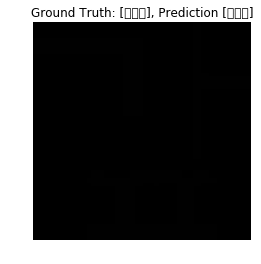

16 17 갚 갛


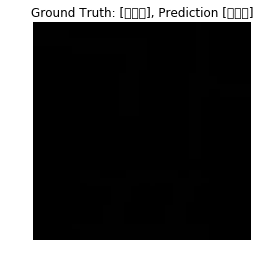

16 17 갚 갛


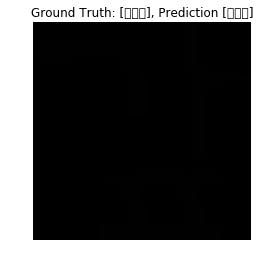

16 17 갚 갛


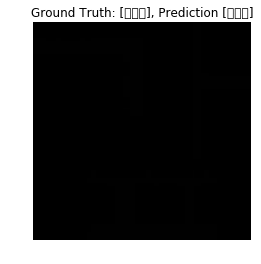

16 17 갚 갛


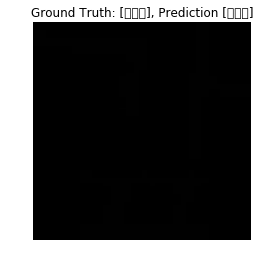

16 17 갚 갛


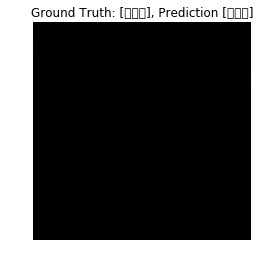

16 17 갚 갛


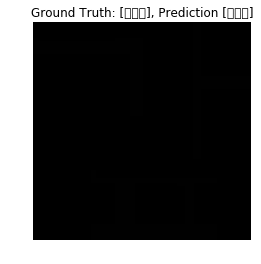

16 17 갚 갛


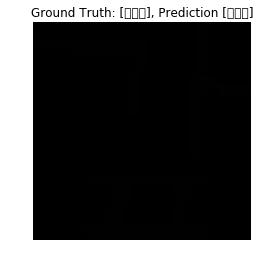

16 17 갚 갛


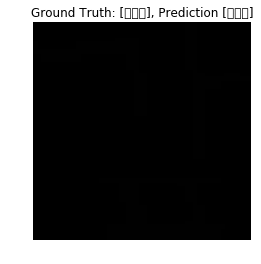

16 17 갚 갛


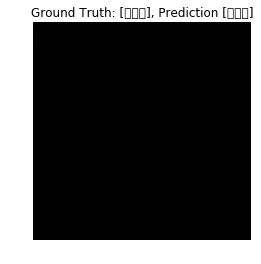

16 17 갚 갛


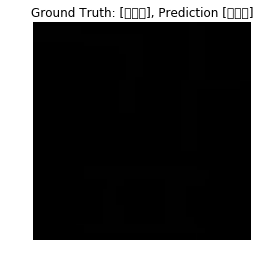

16 17 갚 갛


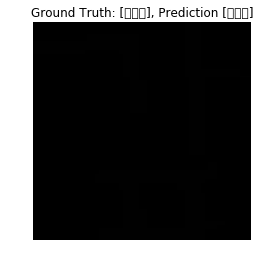

16 17 갚 갛


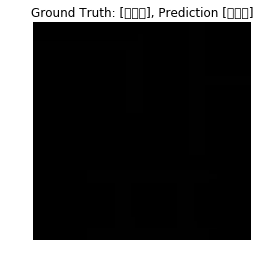

16 17 갚 갛


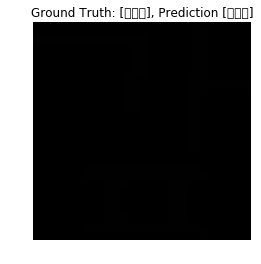

16 17 갚 갛


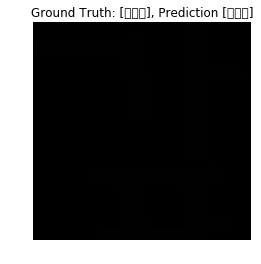

16 17 갚 갛


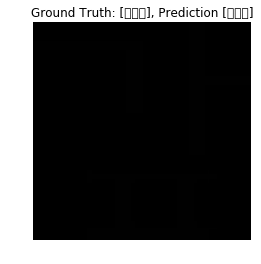

16 17 갚 갛


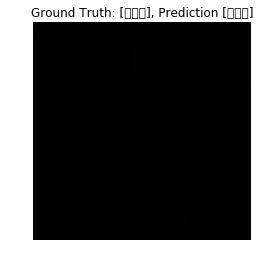

16 17 갚 갛


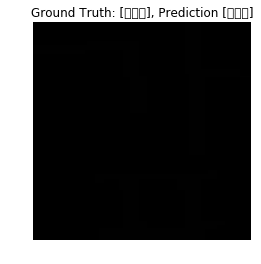

16 17 갚 갛


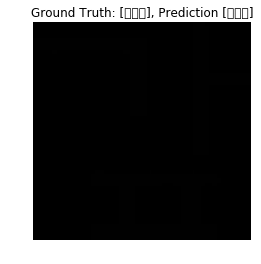

16 17 갚 갛


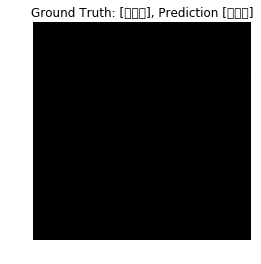

16 17 갚 갛


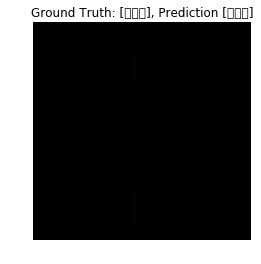

16 17 갚 갛


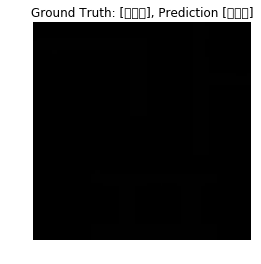

16 17 갚 갛


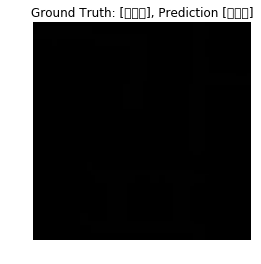

16 17 갚 갛


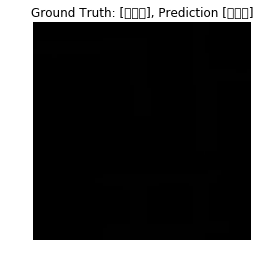

16 17 갚 갛


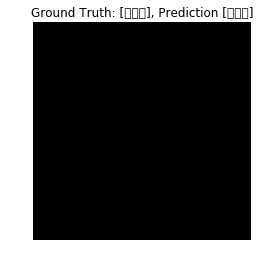

16 17 갚 갛


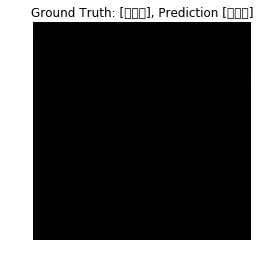

16 17 갚 갛


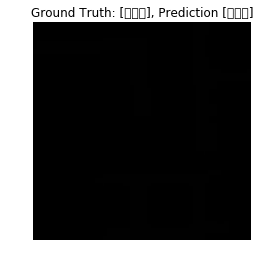

16 17 갚 갛


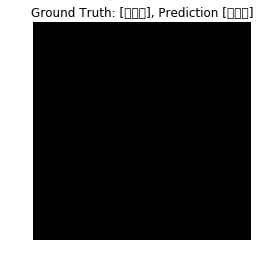

16 17 갚 갛


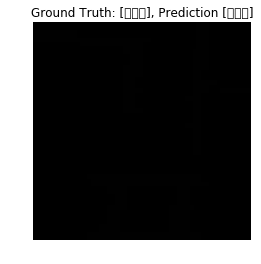

16 17 갚 갛


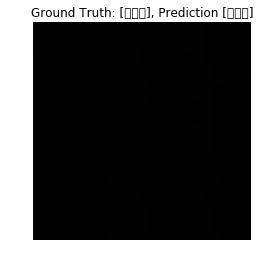

16 17 갚 갛


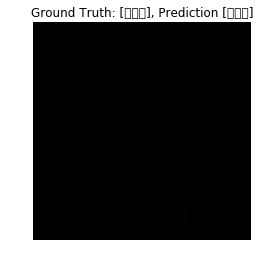

16 17 갚 갛


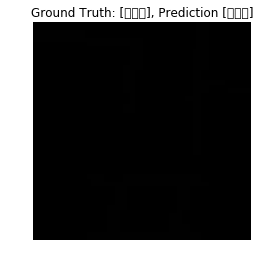

In [23]:
import numpy as np
import tensorflow as tf
from datasets import flowers
from nets import inception

from tensorflow.contrib import slim

image_size = inception.inception_v1.default_image_size
batch_size = 32

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    images, images_raw, labels = get_inputs(height=image_size, width=image_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(images, num_classes=NUM_CLASSES, is_training=True)

    probabilities = tf.nn.softmax(logits)
    
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    init_fn = slim.assign_from_checkpoint_fn(
      checkpoint_path,
      slim.get_variables_to_restore())
    
    with tf.Session() as sess:
        with slim.queues.QueueRunners(sess):
            sess.run(tf.initialize_local_variables())
            init_fn(sess)
            np_probabilities, np_images_raw, np_labels = sess.run([probabilities, images_raw, labels])
    
            for i in range(batch_size): 
                image = np_images_raw[i, :, :, :]
                true_label = np_labels[i]
                predicted_label = np.argmax(np_probabilities[i, :])
                predicted_name = label_name[predicted_label]
                true_name = label_name[true_label]
                
                print(true_label, predicted_label, true_name, predicted_name)
                
                plt.figure()
                plt.imshow(image.astype(np.uint8))
                plt.title('Ground Truth: [%s], Prediction [%s]' % (true_name, predicted_name))
                plt.axis('off')
                plt.show()